In [3]:
import numpy as np
import glob

# for plotting
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
#from matplotlib.colors import LogNorm
%matplotlib inline

from PIL import Image 
# Nedded for background fit
import numpy.polynomial.polynomial as poly
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy import optimize

# needed for spotfinder
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters

# custom functions
from ..Core.DefDefDefinitions import PE_Vals
from DefDefDefinitions import Image_Converter
from DefDefDefinitions import FrequencyFilterFunction
from DefDefDefinitions import FFT_Filter
from DefDefDefinitions import Unique_Circle
from DefDefDefinitions import Fit_2D_Gaussian
from DefDefDefinitions import gaussian_2d
from DefDefDefinitions import Spot_finder
from DefDefDefinitions import Spot_Area
from DefDefDefinitions import Step_fit
from DefDefDefinitions import Line_fit
from DefDefDefinitions import moving_average
from DefDefDefinitions import Trajectory

ValueError: attempted relative import beyond top-level package

In [7]:
from matplotlib import cm

In [2]:
Dir = '/Users/austinmcdonald/Desktop/102919/bar-10/'

In [3]:
DataFiles = glob.glob(Dir+'*')
DataFiles.sort()
DataFiles = DataFiles[0:300]


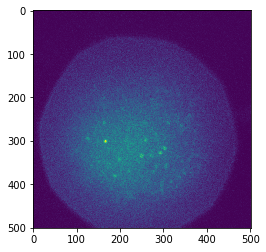

In [4]:
Row    = int(250)
Col    = Row
Yindex = int(256)
Xindex = int(256)

eOffset, eCoeff = PE_Vals(DataFiles[0])
Test = Image_Converter(DataFiles[0], eOffset, eCoeff, Xindex, Yindex, Row, Col)

plt.imshow(Test)

In [5]:
Shape = Test.shape[0]
SUMMED = np.zeros(Shape**2).reshape((Shape,Shape))

FreqCut=0.03
FreqCutWidth=0.04
#Filter=lambda x: (0.5+np.tanh((x-FreqCut)/FreqCutWidth)/2.)
#plot it
#plt.title("Frequency filter function'")
#vars=np.arange(0,0.5,0.01)
#plt.plot(vars,Filter(vars))
        
FilterArray = FrequencyFilterFunction(Shape,FreqCut,FreqCutWidth)

In [6]:

FRAMES = {}
for img in DataFiles:
    DirName    = img.split('/')[-2]
    FileName   = img.split('/')[-1]
    FrameIndex = FileName.split('_')[-1].split('.tif')[0]
    FrameName  = DirName+'_'+FrameIndex

    eOffset, eCoeff = PE_Vals(img)
    ReducedImage = Image_Converter(img, eOffset, eCoeff, Xindex, Yindex, Row, Col)
    SUMMED += ReducedImage
    
    FRAMES[FrameName] = FFT_Filter(ReducedImage, FilterArray)
    
SUMMED = SUMMED/len(DataFiles)

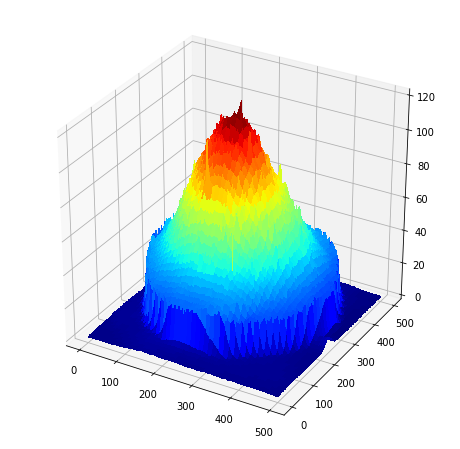

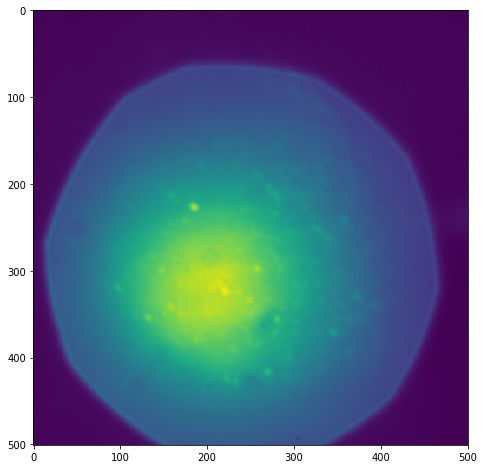

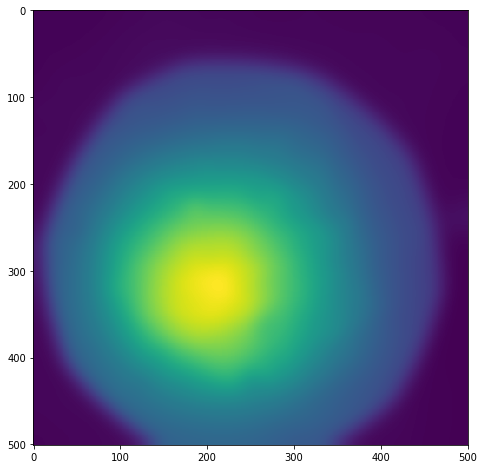

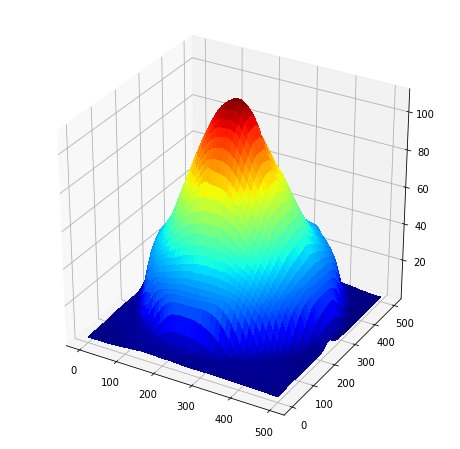

In [100]:
plt.figure(figsize=(8,8))
ax = plt.subplot(111, projection='3d')
data = SUMMED-np.min(SUMMED)
ypos, xpos  = np.indices(data.shape) 
ax.plot_surface(xpos, ypos, data, cmap=cm.jet,linewidth=0, antialiased=False)
plt.show()

plt.figure(figsize=(8,8))
plt.imshow(data)
plt.show()

blur = ndimage.gaussian_filter(data,10)
plt.figure(figsize=(8,8))
plt.imshow(blur)
plt.show()

plt.figure(figsize=(8,8))
ax = plt.subplot(111, projection='3d')
ax.plot_surface(xpos, ypos, blur, cmap=cm.jet,linewidth=0, antialiased=False)
plt.show()



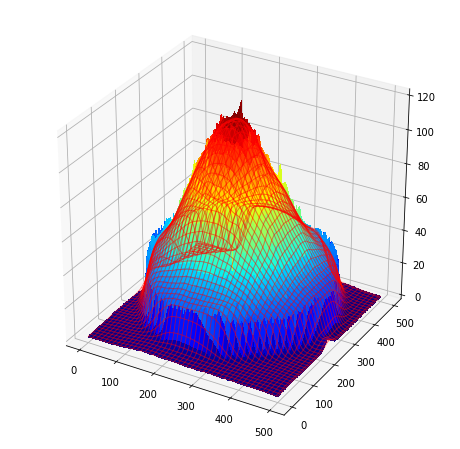

In [101]:
plt.figure(figsize=(8,8))

ax = plt.subplot(111, projection='3d')
ax.plot_surface(xpos, ypos, data, cmap=cm.jet,linewidth=0, antialiased=False)
ax.plot_wireframe(xpos, ypos, blur, color='r',linewidth=1,alpha=0.5)

plt.show()

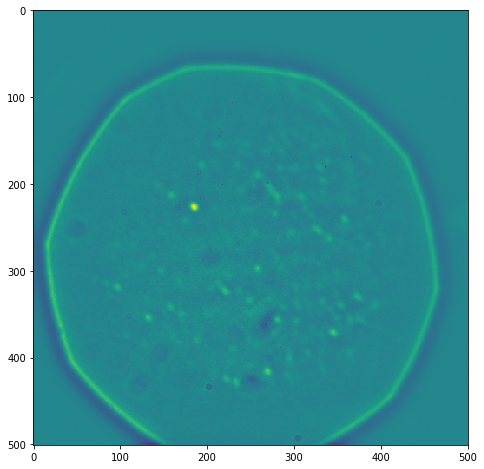

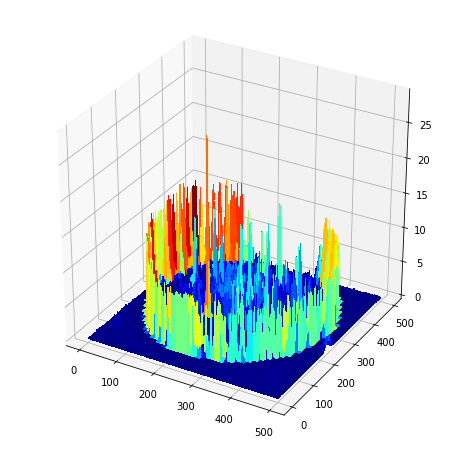

In [102]:
plt.figure(figsize=(8,8))
plt.imshow(data-blur)
plt.show()

plt.figure(figsize=(8,8))
ax = plt.subplot(111, projection='3d')
fix = data-blur
fix[fix<0]=0
ax.plot_surface(xpos, ypos, fix, cmap=cm.jet,linewidth=0, antialiased=False)
plt.show()

In [103]:
KEYS = list(FRAMES.keys())
SUMMEDFFT = np.zeros(Shape**2).reshape((Shape,Shape))
for keys in KEYS:
    SUMMEDFFT += FRAMES[keys]

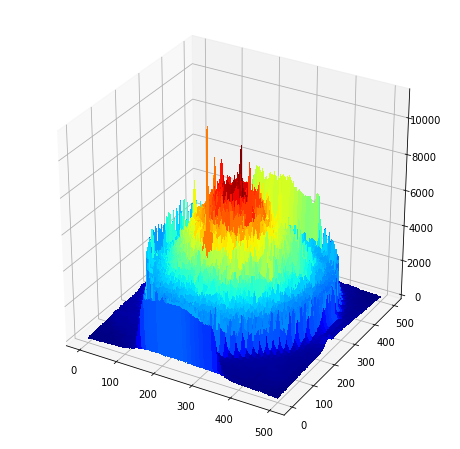

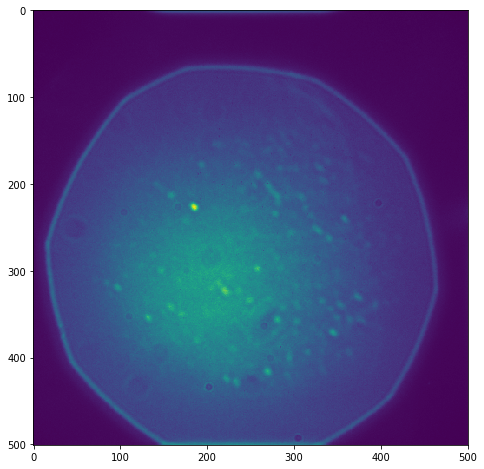

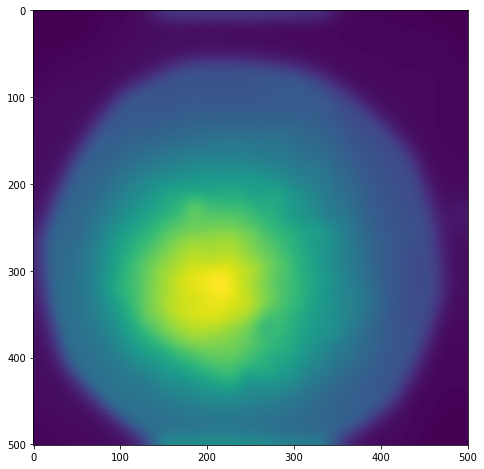

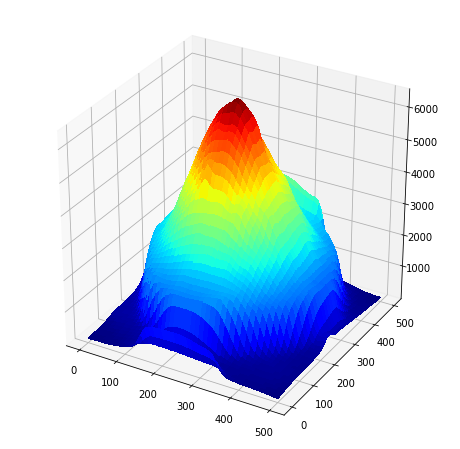

In [104]:
plt.figure(figsize=(8,8))
ax = plt.subplot(111, projection='3d')
data = SUMMEDFFT-np.min(SUMMEDFFT)
ypos, xpos  = np.indices(data.shape) 
ax.plot_surface(xpos, ypos, data, cmap=cm.jet,linewidth=0, antialiased=False)
plt.show()

plt.figure(figsize=(8,8))
plt.imshow(data)
plt.show()

blur = ndimage.gaussian_filter(data,10)
plt.figure(figsize=(8,8))
plt.imshow(blur)
plt.show()

plt.figure(figsize=(8,8))
ax = plt.subplot(111, projection='3d')
ax.plot_surface(xpos, ypos, blur, cmap=cm.jet,linewidth=0, antialiased=False)
plt.show()



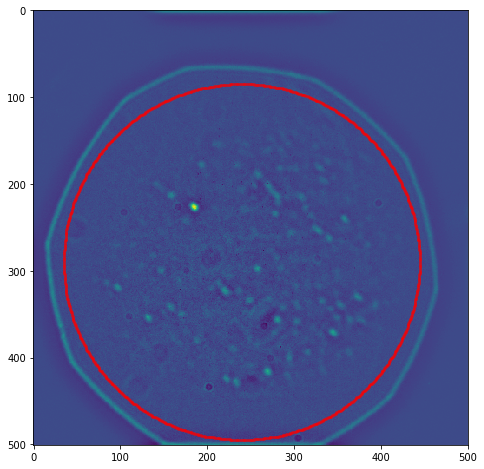

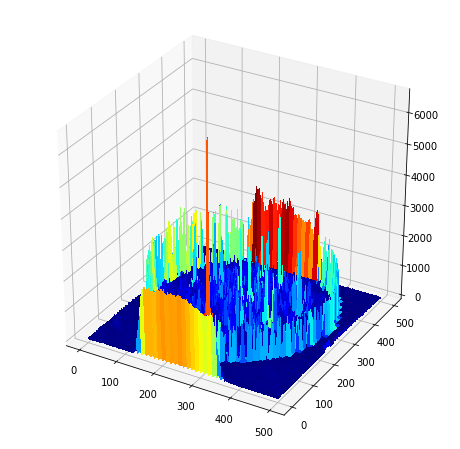

In [105]:
plt.figure(figsize=(8,8))
plt.imshow(data-blur)
r = 205
Xoff = 240
Yoff = 290
X_circle, Y_circle = Unique_Circle(r, Xoff, Yoff)

keep = np.where(Y_circle<Shape)
Y_circle = Y_circle[keep]
X_circle = X_circle[keep]
keep = np.where(X_circle<Shape)
Y_circle = Y_circle[keep]
X_circle = X_circle[keep]

plt.scatter(X_circle,Y_circle,color='r',lw=2,alpha=0.4,s=1)


plt.show()

plt.figure(figsize=(8,8))
ax = plt.subplot(111, projection='3d')
fix = data-blur
fix[fix<0]=0
ax.plot_surface(xpos, ypos, fix, cmap=cm.jet,linewidth=0, antialiased=False)
plt.show()

In [106]:
TEST  = np.zeros(Shape**2).reshape((Shape,Shape))
r_cut  = np.sqrt((X_circle-Xoff)**2+(Y_circle-Yoff)**2).max()
for r in range(SUMMEDFFT.shape[0]):
    for c in range(SUMMEDFFT.shape[0]):
        rr = np.sqrt((r-Yoff)**2+(c-Xoff)**2)
        if rr<=r_cut:
            TEST[r,c]=1

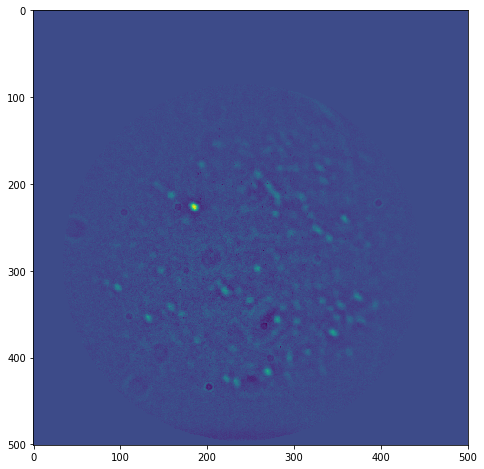

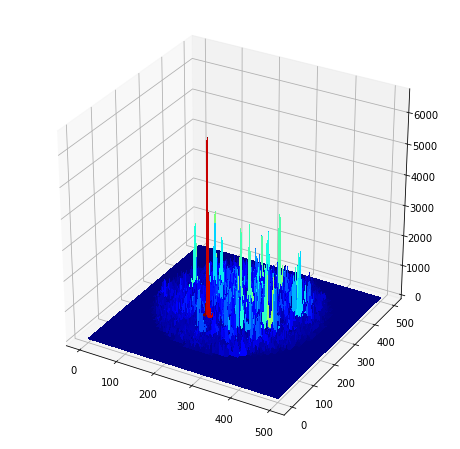

In [107]:
plt.figure(figsize=(8,8))
plt.imshow((data-blur)*TEST)

plt.show()

plt.figure(figsize=(8,8))
ax = plt.subplot(111, projection='3d')
fix = (data-blur)*TEST
fix[fix<0]=0
ax.plot_surface(xpos, ypos, fix, cmap=cm.jet,linewidth=0, antialiased=False)
plt.show()

In [108]:
neighborhood_size = 14
threshold_sigma = 3
EdgeCut = 5  
spots = Spot_finder(fix, neighborhood_size, threshold_sigma, Shape, EdgeCut)
print("found spots ", len(spots))

found spots  235


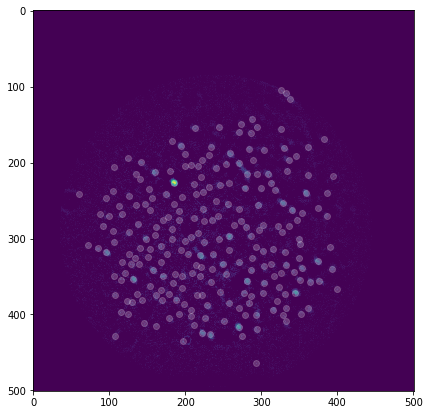

In [109]:
plt.figure(figsize=(7,7))
plt.imshow(fix)
plt.scatter(spots[:,0],spots[:,1],color='w',alpha=0.2)
plt.show()

In [45]:
SpotKiller = np.ones(Shape**2).reshape((Shape,Shape))
Rsig = int(7)
#spotSIG = np.array(Dict[keys][Yindex-Rsig:Yindex+Rsig+1,Xindex-Rsig:Xindex+Rsig+1])
for spo in spots:
    Xindex = int(spo[0])
    Yindex = int(spo[1])
    SpotKiller[Yindex-Rsig:Yindex+Rsig+1,Xindex-Rsig:Xindex+Rsig+1] = 0
        

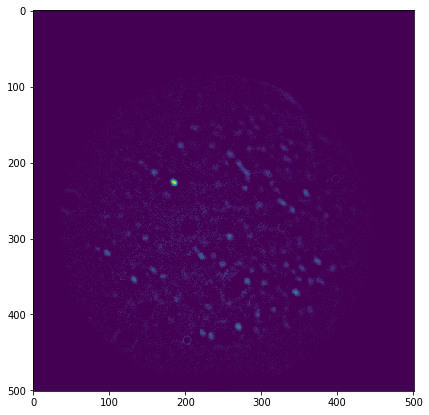

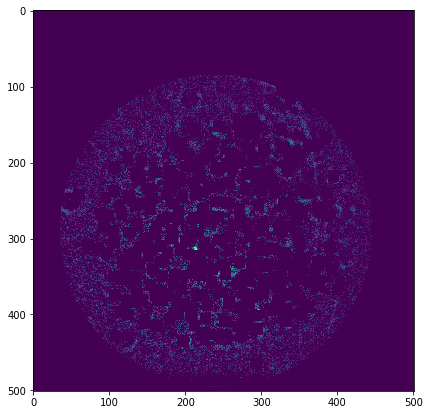

In [46]:
plt.figure(figsize=(7,7))
plt.imshow(fix)
plt.show()

plt.figure(figsize=(7,7))
plt.imshow(fix*SpotKiller)
plt.show()

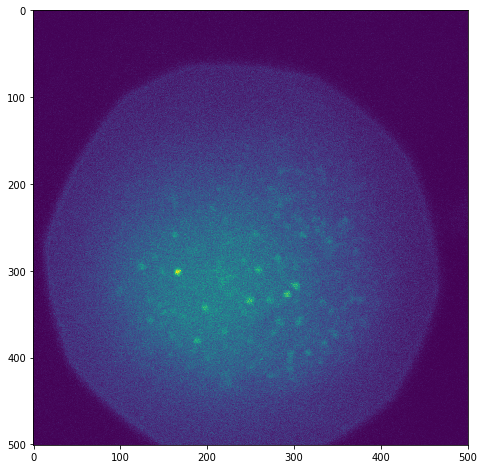

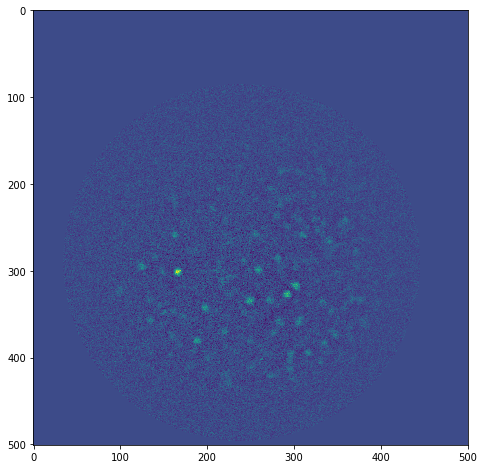

In [55]:
plt.figure(figsize=(8,8))
plt.imshow(Test)
plt.show()

blur2 = ndimage.gaussian_filter(Test,10)
plt.figure(figsize=(8,8))
plt.imshow((Test-blur2)*TEST)
plt.show()


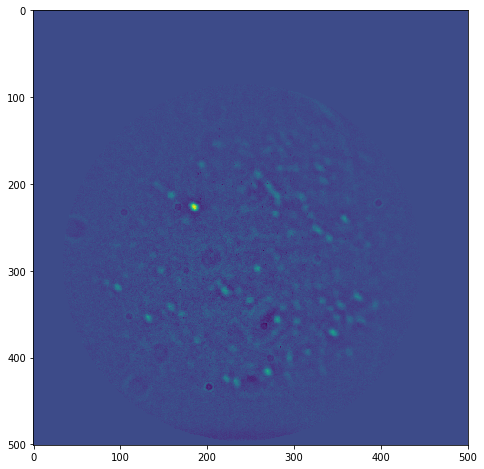

In [62]:
SUMMED2 = np.zeros(Shape**2).reshape((Shape,Shape))
Row    = int(250)
Col    = Row
Yindex = int(256)
Xindex = int(256)
for img in DataFiles:
    eOffset, eCoeff = PE_Vals(img)
    ReducedImage = Image_Converter(img, eOffset, eCoeff, Xindex, Yindex, Row, Col)
    blurt = ndimage.gaussian_filter(ReducedImage,10)
    #FFT_Filter(ReducedImage, FilterArray)
    SUMMED2 += (ReducedImage-blurt)*TEST
        
SUMMED2 = SUMMED2/len(DataFiles)

plt.figure(figsize=(8,8))
plt.imshow(SUMMED2)
plt.show()

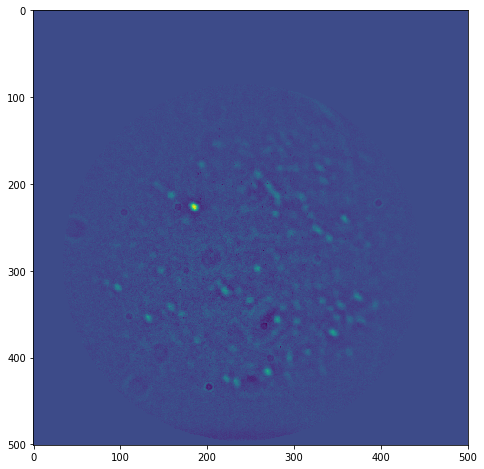

In [63]:
plt.figure(figsize=(8,8))
plt.imshow((data-blur)*TEST)

plt.show()

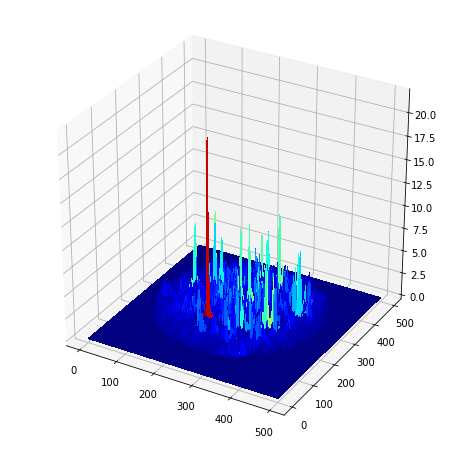

In [64]:
plt.figure(figsize=(8,8))
ax = plt.subplot(111, projection='3d')
fix2 = SUMMED2
fix2[fix2<0]=0
ax.plot_surface(xpos, ypos, fix2, cmap=cm.jet,linewidth=0, antialiased=False)
plt.show()

In [89]:

FRAMES2 = {}
for img in DataFiles:
    DirName    = img.split('/')[-2]
    FileName   = img.split('/')[-1]
    FrameIndex = FileName.split('_')[-1].split('.tif')[0]
    FrameName  = DirName+'_'+FrameIndex

    eOffset, eCoeff = PE_Vals(img)
    ReducedImage = Image_Converter(img, eOffset, eCoeff, Xindex, Yindex, Row, Col)
    blurt = ndimage.gaussian_filter(ReducedImage,10)
    holder = (ReducedImage-blurt)*TEST
    holder[holder<0]=0
    FRAMES2[FrameName] = holder

In [90]:
neighborhood_size = 14
threshold_sigma = 3
EdgeCut = 5  
spots = Spot_finder(SUMMED2, neighborhood_size, threshold_sigma, Shape, EdgeCut)
print("found spots ", len(spots))

found spots  235


In [110]:
KEYS = list(FRAMES.keys())
Rbkg = int(7)
Rsig = int(4)
spot_area = Spot_Area(FRAMES, KEYS, spots, Rbkg, Rsig)

In [111]:
Traject = {}
AVG = 1
Num_Spots = len(spots)
print("found "+str(Num_Spots)+" spots!")
#for x in range(0,1):
for x in range(0,Num_Spots):
    X = str(int(spots[x][0]))
    Y = str(int(spots[x][1]))
    NAME = "X"+X+"_Y"+Y
    sig = np.array(spot_area[x::Num_Spots])[:,2]
    bkg = np.array(spot_area[x::Num_Spots])[:,3]

    sig = np.add.reduceat(sig, np.arange(0, len(sig), AVG))
    bak = np.add.reduceat(bkg, np.arange(0, len(bkg), AVG))
    times    = np.arange(0,len(sig))*0.5*AVG

    baerry = np.sqrt(sig*(2*Rsig+1)**2)
    naerry = np.sqrt(bak*((2*Rbkg+1)**2-(2*Rsig+1)**2))
    coefsF = poly.polyfit(times,bak, 3)
    ffitF  = poly.polyval(times, coefsF)


    fitS = (sig-ffitF)
    fitSbk = baerry/(2*Rsig+1)**2
    fitB = (bak-ffitF)
    fitBbk = naerry/((2*Rbkg+1)**2-(2*Rsig+1)**2)

    Meandiff, chiStep, LT = Step_fit(times,fitS,fitSbk)
    chiLine     = Line_fit(times,fitS,fitSbk)

    Trj = Trajectory()
    Trj.name = NAME
    Trj.Mean_diff = Meandiff
    Trj.Chi_Step = chiStep
    Trj.Chi_Line = chiLine
    Trj.Step_Time = LT
    Trj.Times = times
    Trj.Signal = fitS
    Trj.Signal_er = fitSbk
    Trj.Background = fitB
    Trj.Background_er = fitBbk


    Traject[NAME] = Trj

found 235 spots!


In [112]:
TKEYS = Traject.keys()

(-10, 20)

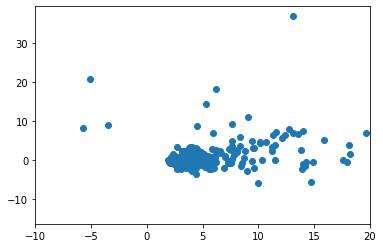

In [113]:
MD = []
chid = []
for key in TKEYS:
    MD.append(Traject[key].Mean_diff)
    chid.append(Traject[key].Chi_Step-Traject[key].Chi_Line)
    
    
plt.scatter(chid,MD)
plt.xlim(-10,20)

X284_Y182


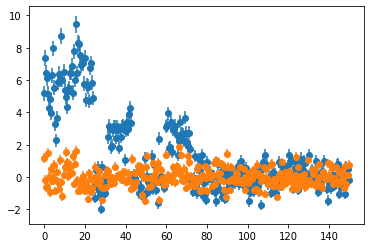

X294_Y215


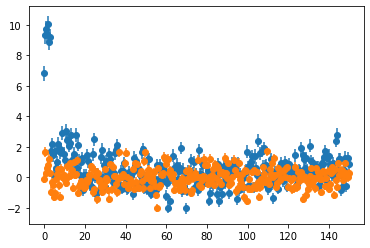

X279_Y234


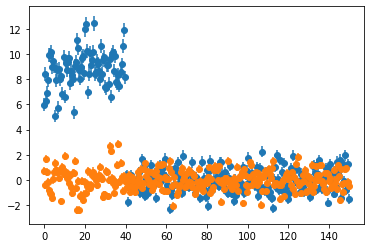

X359_Y240


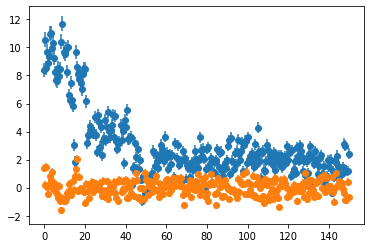

X329_Y253


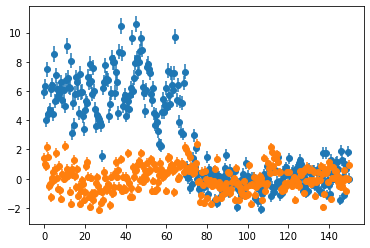

X137_Y281


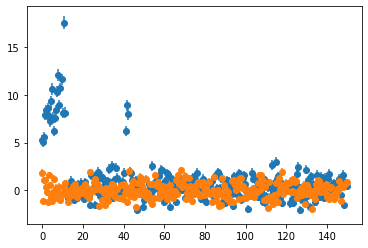

X280_Y285


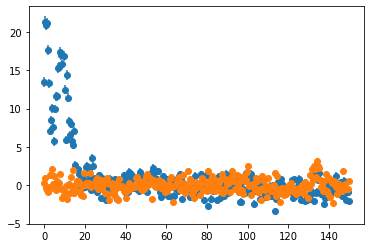

X126_Y292


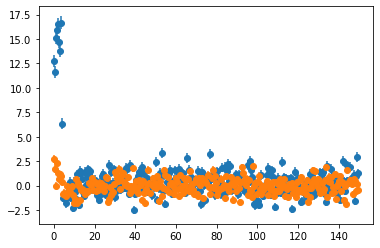

X258_Y297


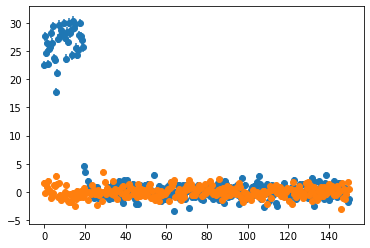

X148_Y300


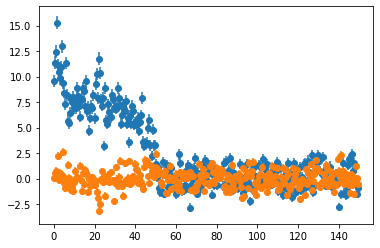

X302_Y316


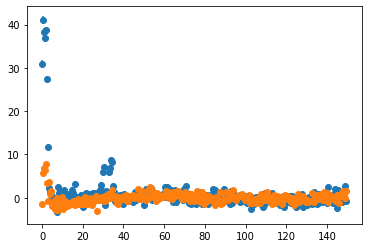

X288_Y326


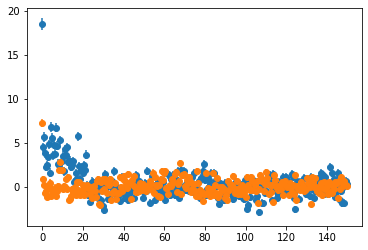

X271_Y331


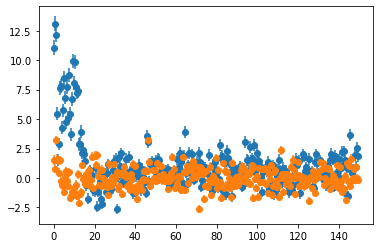

X249_Y334


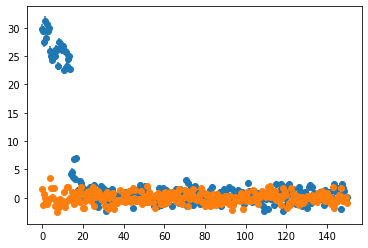

X332_Y335


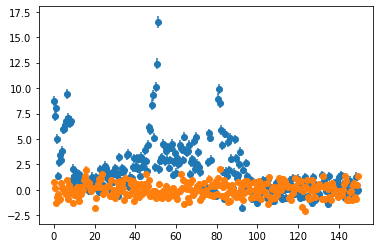

X343_Y344


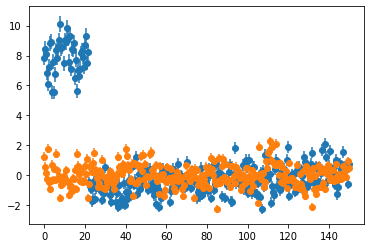

X131_Y353


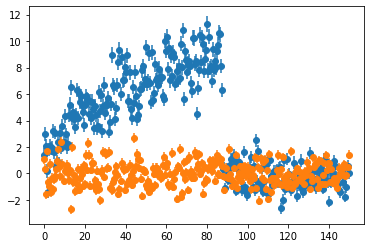

X281_Y356


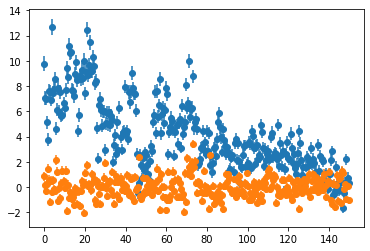

X303_Y359


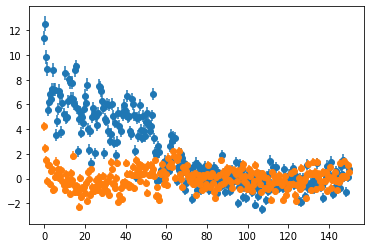

X277_Y372


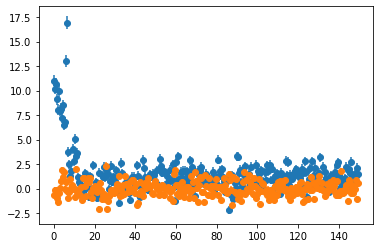

X345_Y372


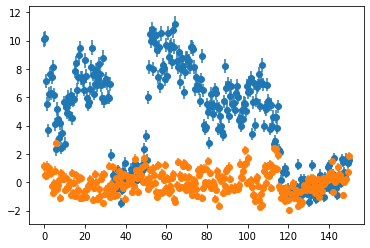

X161_Y375


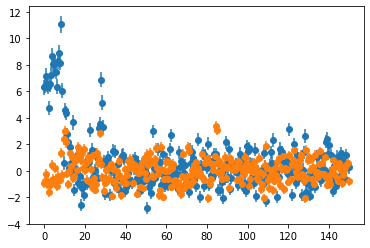

X188_Y381


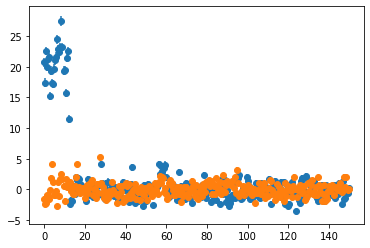

In [ ]:
for key in TKEYS:
    if Traject[key].Mean_diff < 5:
        continue
    print(key)
    plt.errorbar(Traject[key].Times,Traject[key].Signal,
                 yerr=Traject[key].Signal_er,fmt='o')
    plt.errorbar(Traject[key].Times,Traject[key].Background,
                 yerr=Traject[key].Background_er,fmt='o')
    plt.show()

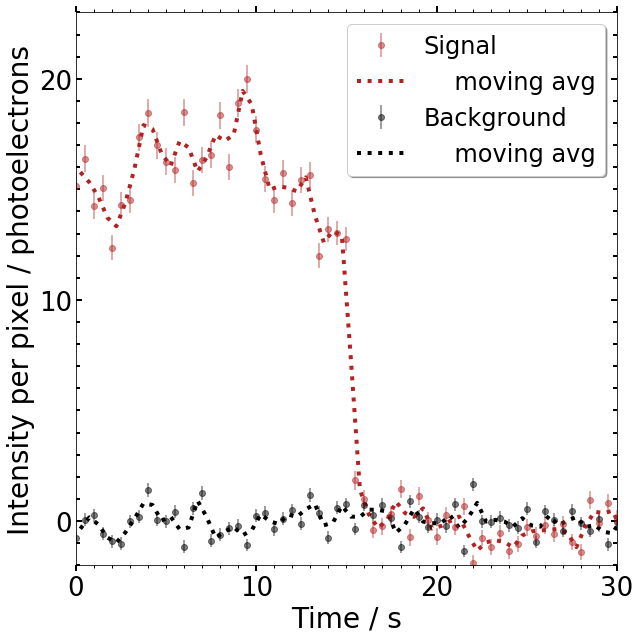

In [50]:
mv_avg = 2
fig, ax = plt.subplots(figsize=(9,9))

ax.errorbar(Traject['X316_Y394'].Times ,Traject['X316_Y394'].Background,
             yerr=Traject['X316_Y394'].Background_er, fmt='o', alpha=0.5,label='Background',color='k')
xx = moving_average(Traject['X316_Y394'].Times,mv_avg)
yy = moving_average(Traject['X316_Y394'].Background,mv_avg)
ax.plot(xx,yy,color='k',label='moving avg',linestyle=':',linewidth=4)


ax.errorbar(Traject['X316_Y394'].Times ,Traject['X316_Y394'].Signal,
             yerr=Traject['X316_Y394'].Signal_er, fmt='o', alpha=0.5,label='Signal',color='firebrick')
xx = moving_average(Traject['X316_Y394'].Times,mv_avg)
yy = moving_average(Traject['X316_Y394'].Signal,mv_avg)
ax.plot(xx,yy,color='firebrick',label='moving avg',linestyle=':',linewidth=4)



ax.set_xlabel(r'Time / s', fontsize=28)
ax.set_ylabel('Intensity per pixel / photoelectrons', fontsize=28)

handles,labels = ax.get_legend_handles_labels()
handles = [handles[3], handles[1], handles[2], handles[0]]


labels = [labels[3], '    '+labels[1], labels[2], '    '+labels[0]]
ax.legend(handles,labels,fontsize=24,shadow=True, fancybox=True)

plt.xticks(fontsize = 26)
plt.yticks(fontsize = 26)

xmajor_ticks = np.arange(0, 400, 10)
xminor_ticks = np.arange(0, 400, 1)
ymajor_ticks = np.arange(0, 70, 10)
yminor_ticks = np.arange(-5, 70, 1)
ax.tick_params(axis = 'x', which = 'major', direction='out',width=2,length=6,top="off",right='off')
ax.tick_params(axis = 'x', which = 'minor', direction='out',width=1,length=3,top="off",right='off')

ax.tick_params(axis = 'y', which = 'major', direction='in',width=2,length=6,top="off",right='off')
ax.tick_params(axis = 'y', which = 'minor', direction='in',width=2,length=4,top="off",right='off')

ax.set_xticks(xmajor_ticks)
ax.set_xticks(xminor_ticks, minor = True)
ax.set_yticks(ymajor_ticks)
ax.set_yticks(yminor_ticks, minor = True)

ax.set_xlim(0,30)
ax.set_ylim(-2,23)
#plt.grid(True)
plt.tight_layout()
#plt.savefig('/Users/austinmcdonald/Desktop/HP-step.png',dpi=400)
plt.show()

In [55]:
from matplotlib.colors import LogNorm


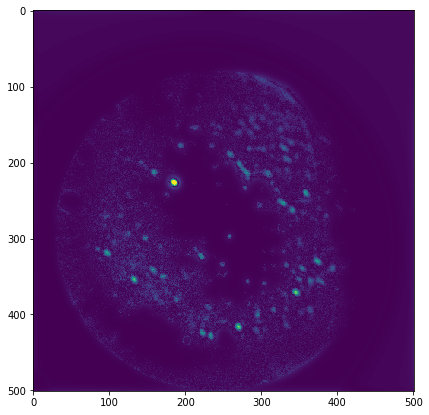

In [70]:
plt.figure(figsize=(7,7))
plt.imshow(InvSlideFFT)
plt.clim(0,15)
plt.show()

In [67]:
np.min(InvSlideFFT)

3.7604903558918652e-06